### Imports and Definitions

In [1]:
from datetime import datetime
from gzip import open as gopen
from math import exp,log,log10
from matplotlib import rcParams
from matplotlib.patches import Patch
from os.path import isfile
from pickle import load,dump
from random import shuffle
from scipy.stats import kendalltau
from seaborn import pointplot,set_context,set_style,stripplot,violinplot
from treeswift import read_tree_newick
import matplotlib.pyplot as plt
TN93THRESH = 0.015
RC = {"font.size":12,"axes.titlesize":16,"axes.labelsize":14,"legend.fontsize":10,"xtick.labelsize":10,"ytick.labelsize":10}
set_context("paper", rc=RC); set_style("ticks"); rcParams['font.family'] = 'serif'

In [2]:
def p_to_star(p):
    if p <= 0.0001:
        return '****'
    elif p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return ''

def avg(x):
    return sum(x)/len(x)

### Helper Function to Load FASTA

In [3]:
def read_FASTA(filename):
    seqs = {}
    name = None
    seq = ''
    if filename.lower().endswith('.gz'):
        f = gopen(filename)
    else:
        f = open(filename)
    for line in f:
        if isinstance(line,bytes):
            l = line.decode().strip()
        else:
            l = line.strip()
        if len(l) == 0:
            continue
        if l[0] == '>':
            if name is not None:
                assert len(seq) != 0, "Malformed FASTA"
                seqs[name] = seq
            name = l[1:]
            assert name not in seqs, "Duplicate sequence ID: %s" % name
            seq = ''
        else:
            seq += l
    f.close()
    assert name is not None and len(seq) != 0, "Malformed FASTA"
    seqs[name] = seq
    return seqs

### Helper Function to Load tn93 Output as Distance Matrix

In [4]:
def read_tn93(filename):
    dm = dict()
    if filename.lower().endswith('.gz'):
        f = gopen(filename)
    else:
        f = open(filename)
    for line in f:
        if isinstance(line,bytes):
            l = line.decode().strip()
        else:
            l = line.strip()
        u,v,d = l.split(',')
        if d == 'Distance':
            continue
        d = float(d)
        if u not in dm:
            dm[u] = dict()
        if v not in dm:
            dm[v] = dict()
        dm[u][v] = d; dm[v][u] = d
    return dm

### Helper Functions to Compute Cumulative Moving Average

In [5]:
# get the Cumulative Moving Average (CMA) over all indices
def cma(x):
    y = [x[0]]
    for i in range(1,len(x)):
        y.append(y[-1]+x[i])
    for i in range(len(y)):
        y[i] /= (i+1)
    return y

# helper function to compute the test statistic
def cma_test_stat(y,normalize=False):
    if normalize:
        sum_miny = sum(cma(sorted(x)))
        return (sum(y)-sum_miny)/(sum(cma(sorted(x,reverse=True)))-sum_miny) # AUC of CMA, normalized so min = 0 and max = 1
    else:
        return sum(y) # AUC of CMA

# returns (stat,p,cma_dist,stat_dist). "side" is "left" or "right"
def cma_test(x,side,bg_cma=None,bg_stat=None,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    y = cma(x)
    stat = cma_test_stat(y)
    if bg_cma is None or bg_stat is None:
        cma_dist = list(); stat_dist = list()
        for _ in range(it):
            tmp = x[:]; shuffle(tmp); tmp_cma = cma(tmp)
            cma_dist.append(tmp_cma)
            stat_dist.append(cma_test_stat(tmp_cma))
    else:
        cma_dist = bg_cma; stat_dist = bg_stat
    if side == 'right':
        p = sum(e >= stat for e in stat_dist)/len(stat_dist)
    elif side == 'left':
        p = sum(e <= stat for e in stat_dist)/len(stat_dist)
    return stat,p,cma_dist,stat_dist

### Helper Functions to Kendall’s Tau Test

In [6]:
# compute the Kendall's tau
def tau(om):
    t,p = kendalltau(om, list(range(len(om)-1,-1,-1))) # p is 2-sided
    return (t,p/2.)

# returns (stat,p,stat_dist)
def tau_test(om,side,bg=None,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    t,p = tau(om)
    if bg is None:
        tau_dist = list()
        for _ in range(it):
            tmp = om[:]; shuffle(tmp); tau_dist.append(tau(tmp)[0])
    else:
        tau_dist = bg
    #if side == 'right':
    #    p = sum(e >= t for e in tau_dist)/len(tau_dist)
    #elif side == 'left':
    #    p = sum(e <= t for e in tau_dist)/len(tau_dist)
    return t,p,tau_dist

# Real Data

### Load Data

In [7]:
data = {
    'seqs': read_FASTA('../real_data/sd.full.aln.gz'),
    'tn93': read_tn93('../real_data/sd.full.tn93.csv.gz'),
    'time': {t:{l.decode().strip().split()[0]:int(l.decode().strip().split()[1]) for l in gopen('../real_data/sd.time.%s.tsv.gz'%t)} for t in ['sample','diagnosis','infection']},
    'proact': {n:{t:gopen('../real_data/sd.%s.%s.mv.proact.txt.gz'%(n,t)).read().decode().strip().splitlines() for t in ['ft','iq']} for n in ['10','20','30','40','50','60','70','80','90','full']},
    'hivtrace': {n:gopen('../real_data/sd.%s.hivtrace.txt.gz'%n).read().decode().strip().splitlines() for n in ['10','20','30','40','50','60','70','80','90','full']},
}
metareal = {
    'label': {
        'ft': 'FastTree',
        'iq': 'IQ-TREE',
        'proact': 'ProACT',
        'max': 'Optimal',
        'bg': 'Null Distribution',
        'hivtrace': 'GD + Cluster Growth',
    },
    'color': {
        'proact.ft': 'blue',
        'proact.iq': 'red',
        'max': 'black',
        'bg': 'lightgrey',
        'hivtrace': 'orange',
    }
}
DATE = {per:max(datetime.strptime(l.split('_')[1], '%m-%d-%y') for l in data['proact'][per]['iq']) for per in data['proact']}

### Riskiness Score Functions

In [8]:
score_functions = {
    #'Logistic': lambda x: 2.-2./(1.+exp(-x*log(3.)/0.015)), # this is logistic with 1/2 score at 1.5%
    'Logarithmic': lambda x: log(x+0.25)/log(0.25), # this is logarithmic where score = 0 at 75%
    'Step': lambda x: {True:1,False:0}[x <= TN93THRESH], # step function at 1.5%
    # score = (L+1)/(L^(x/threshold)+L), with L = 1/(score at 2*threshold) for the following ones
    r'Sigmoid $(\lambda=100)$': lambda x: (100.+1.)/(100.**(x/TN93THRESH)+100.), # score of 0.01 at 3%
    r'Sigmoid $(\lambda=5)$': lambda x: (5.+1.)/(5.**(x/TN93THRESH)+5.), # score of 0.2 at 3%
}

def newnode_riskiness(u, end, score): # score is a function (one of the values of score_functions)
    if u not in data['tn93']:
        return 0
    return sum(score(data['tn93'][u][v]) for v in data['tn93'][u] if data['time'][s][v] > end)

### Kendall's Tau Test

========== Logarithmic ==========
ProACT (FastTree)
10-th Percentile: 0.369804 (p = 9e-08)
20-th Percentile: 0.181850 (p = 1e-04)
30-th Percentile: 0.163163 (p = 3e-05)
40-th Percentile: 0.156919 (p = 3e-06)
50-th Percentile: 0.167898 (p = 3e-08)
60-th Percentile: 0.163263 (p = 4e-09)
70-th Percentile: 0.133284 (p = 2e-07)
80-th Percentile: 0.131456 (p = 4e-08)
90-th Percentile: 0.129525 (p = 1e-08)

ProACT (IQ-TREE)
10-th Percentile: 0.357382 (p = 2e-07)
20-th Percentile: 0.171157 (p = 3e-04)
30-th Percentile: 0.163216 (p = 3e-05)
40-th Percentile: 0.156802 (p = 3e-06)
50-th Percentile: 0.162119 (p = 9e-08)
60-th Percentile: 0.146116 (p = 1e-07)
70-th Percentile: 0.134534 (p = 2e-07)
80-th Percentile: 0.122774 (p = 3e-07)
90-th Percentile: 0.122386 (p = 6e-08)

GD + Cluster Growth
10-th Percentile: 0.213569 (p = 1e-03)
20-th Percentile: 0.092071 (p = 3e-02)
30-th Percentile: 0.151391 (p = 9e-05)
40-th Percentile: 0.090354 (p = 5e-03)
50-th Percentile: 0.101270 (p = 6e-04)
60-th Percen

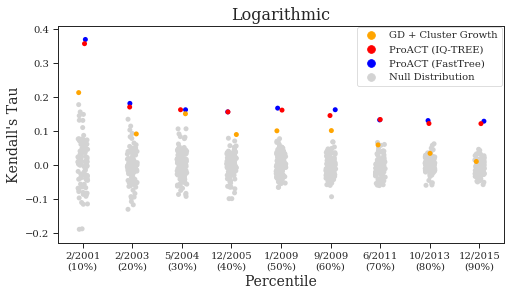

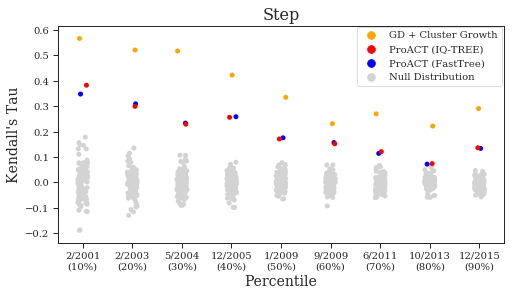

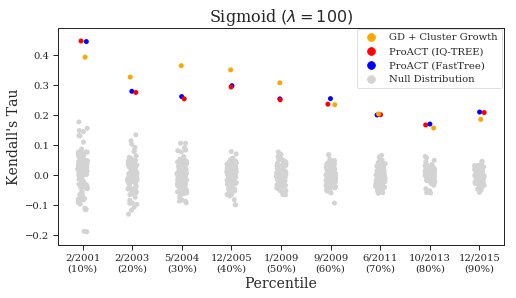

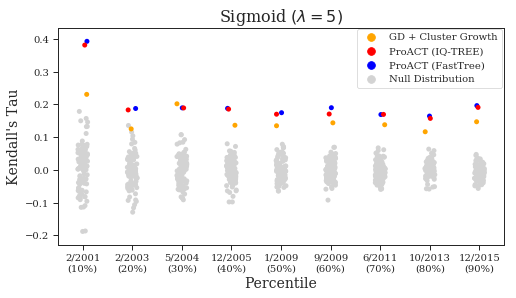

In [9]:
IT = 100; BG = dict()
Ts = ['proact.ft','proact.iq','hivtrace']
for scorename,scorefunc in score_functions.items():
    print("="*10 + ' ' + scorename + ' ' + '='*10)
    ymin = None; ymax = None #ymin = -1; ymax = 1
    for s in ['sample']:
        fig = plt.figure(figsize=(8,4))
        x = list(); y = list(); hue = list(); pal = list(); tmp = list(); pal = [metareal['color']['bg']]
        for t in Ts:
            if t.endswith('.ft') or t.endswith('.iq'):
                label = "%s (%s)"%(metareal['label'][t.split('.')[0]],metareal['label'][t.split('.')[1]])
            else:
                label = metareal['label']['hivtrace']
            print(label)
            for per in ['10','20','30','40','50','60','70','80','90']:
                if per not in BG:
                    BG[per] = None
                if t.endswith('.ft') or t.endswith('.iq'):
                    currdata = data[t.split('.')[0]][per][t.split('.')[1]]
                else:
                    currdata = data['hivtrace'][per]
                END = max(int(l.split('_')[-1]) for l in currdata)
                val = [newnode_riskiness(u,END,scorefunc) for u in currdata]
                taustat,p,tau_dist = tau_test(val,'right',bg=BG[per],it=IT); BG[per] = tau_dist
                print("%s-th Percentile: %f (p = %s)" % (per,taustat,format(p,'.0e')))
                tmp.append((per,taustat,label,metareal['color'][t]))
            print()
        for per in BG:
            for bg in BG[per]:
                x.append("%s\n(%s%%)"%(DATE[per].strftime('%-m/%Y'),per))
                y.append(bg); hue.append(metareal['label']['bg'])
        for per,taustat,h,c in tmp:
            x.append("%s\n(%s%%)"%(DATE[per].strftime('%-m/%Y'),per))
            y.append(taustat); hue.append(h)
            if c not in pal:
                pal.append(c)
        stripplot(x=x,y=y,hue=hue,palette=pal,jitter=True)
        handles,labels = fig.gca().get_legend_handles_labels()
        plt.legend(handles[::-1],labels[::-1],bbox_to_anchor=(0.995, 0.995), loc=1, borderaxespad=0.)
        plt.ylim(ymin=ymin,ymax=ymax)
        plt.title(scorename)
        plt.xlabel("Percentile")
        plt.ylabel("Kendall's Tau")
        fig.savefig('figs/results_tautest_%s.pdf'%scorename, format='pdf', bbox_inches='tight')

# Simulated Data

### Load Data

In [10]:
eff = load(gopen('../simulations/efficacy.pkl.gz'))
metasim = {
    'label': {
        'expected': 'Population Mean',
        'optimal': 'Optimal',
        'optimal.sub25': 'Optimal (25%)',
        'optimal.sub50': 'Optimal (50%)',
        'optimal.sub75': 'Optimal (75%)',
        'hivtrace': 'GD + Cluster Growth',
        'hivtrace.sub25': 'GD + Cluster Growth (25%)',
        'hivtrace.sub50': 'GD + Cluster Growth (50%)',
        'hivtrace.sub75': 'GD + Cluster Growth (75%)',
        'proact.true': 'ProACT (True Trees)',
        'proact.ftmv': 'ProACT (FastTree)',
        'proact.ftmv.sub25': 'ProACT (FastTree, 25%)',
        'proact.ftmv.sub50': 'ProACT (FastTree, 50%)',
        'proact.ftmv.sub75': 'ProACT (FastTree, 75%)',
        'branchlength.true': 'Branch Length (True Trees)',
        'branchlength.ftmv': 'Branch Length (FastTree)',
        'SAMPLE-END_ARTRATE-1': r'ART Rate 1 year$^{-1}$ (Sample End)',
        'SAMPLE-END_ARTRATE-2': r'ART Rate 2 year$^{-1}$ (Sample End)',
        'SAMPLE-END_ARTRATE-4': r'ART Rate 4 year$^{-1}$ (Sample End)',
        'SAMPLE-FIRSTART_ARTRATE-0.5': r'ART Rate 0.5 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-1': r'ART Rate 1 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-2': r'ART Rate 2 year$^{-1}$',
        'SAMPLE-FIRSTART_ARTRATE-4': r'ART Rate 4 year$^{-1}$',
        'SAMPLE-FIRSTART_EXPDEGREE-10': 'Expected Degree 10',
        'SAMPLE-FIRSTART_EXPDEGREE-20': 'Expected Degree 20',
        'SAMPLE-FIRSTART_EXPDEGREE-30': 'Expected Degree 30',
        'SAMPLE-FIRSTART_STOPRATE-0.25x': 'ART Stop Rate 0.25x',
        'SAMPLE-FIRSTART_STOPRATE-0.5x': 'ART Stop Rate 0.5x',
        'SAMPLE-FIRSTART_STOPRATE-1x': 'ART Stop Rate 1x',
        'SAMPLE-FIRSTART_STOPRATE-2x': 'ART Stop Rate 2x',
        'SAMPLE-FIRSTART_STOPRATE-4x': 'ART Stop Rate 4x',
    },
    'color': {
        'expected': 'lightgrey',
        'optimal': 'black',
        'optimal.sub25': 'red',
        'optimal.sub50': 'orange',
        'optimal.sub75': 'gold',
        'hivtrace': 'darkgoldenrod',
        'hivtrace.sub25': 'cornsilk',
        'hivtrace.sub50': 'khaki',
        'hivtrace.sub75': 'goldenrod',
        'proact.true': 'chocolate',
        'proact.ftmv': 'darkblue',
        'proact.ftmv.sub25': 'aqua',
        'proact.ftmv.sub50': 'dodgerblue',
        'proact.ftmv.sub75': 'blue',
        'branchlength.true': 'lightgreen',
        'branchlength.ftmv': 'green',
    },
    'linestyle': {
        'expected': '--',
        'optimal': '--',
        'optimal.sub25': '--',
        'optimal.sub50': '--',
        'optimal.sub75': '--',
        'hivtrace': '-.',
        'hivtrace.sub25': '-.',
        'hivtrace.sub50': '-.',
        'hivtrace.sub75': '-.',
        'proact.true': '-',
        'proact.ftmv': '-',
        'proact.ftmv.sub25': '-',
        'proact.ftmv.sub50': '-',
        'proact.ftmv.sub75': '-',
        'branchlength.true': '-',
        'branchlength.ftmv': '-',
    }
}

## Metric: Number of Infections After Year 9

### Comparing Methods

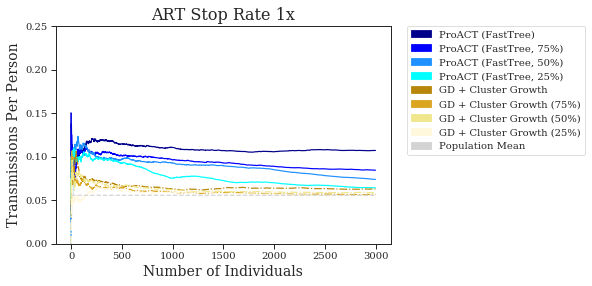

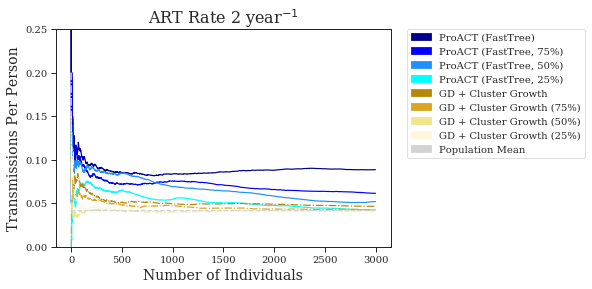

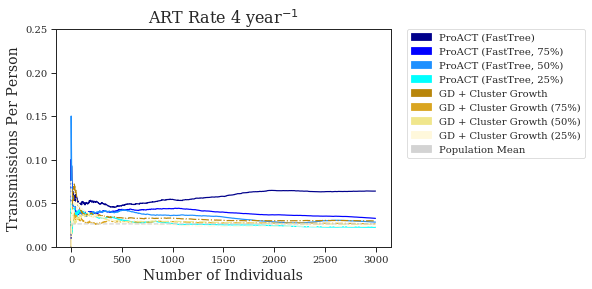

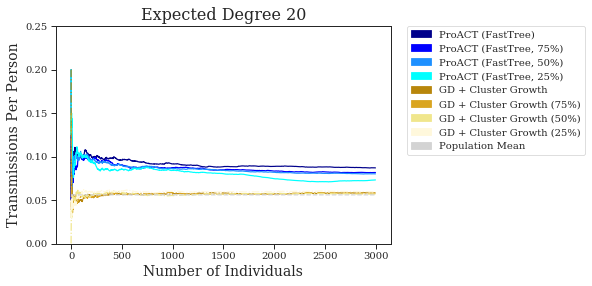

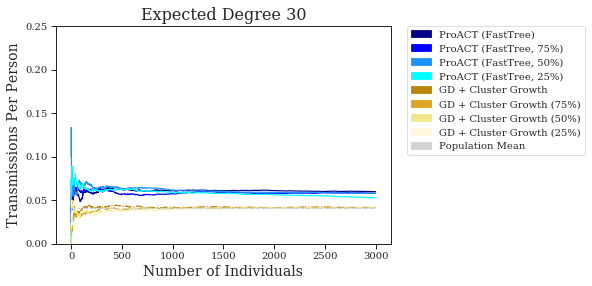

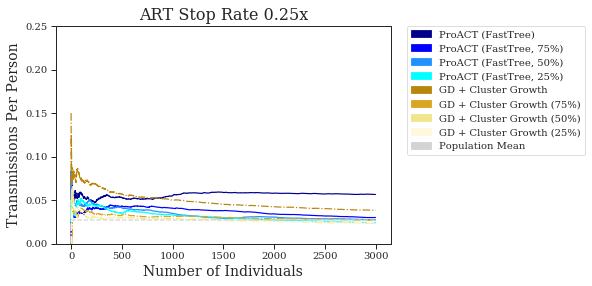

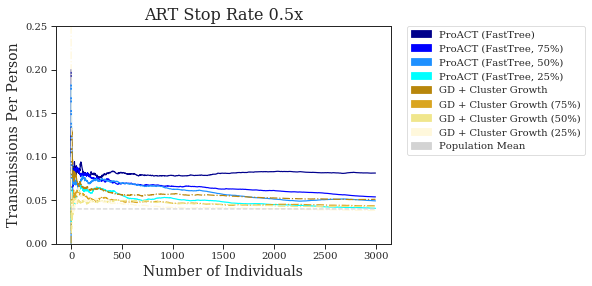

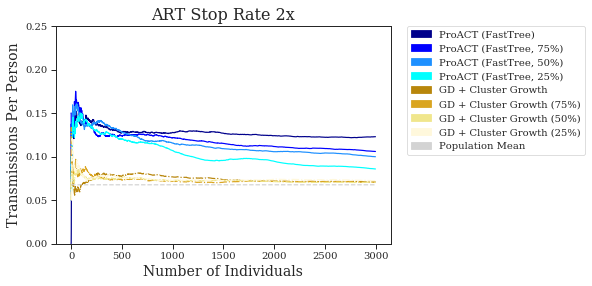

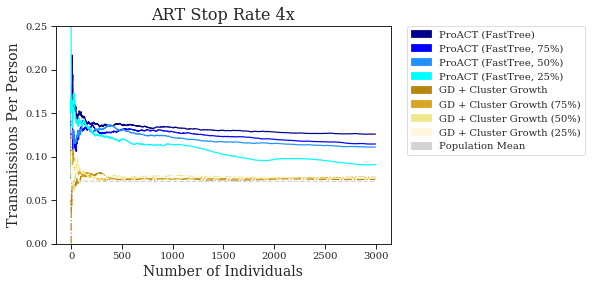

In [11]:
Ms = {
    'main': ['proact.ftmv','proact.ftmv.sub75','proact.ftmv.sub50','proact.ftmv.sub25','hivtrace','hivtrace.sub75','hivtrace.sub50','hivtrace.sub25','expected'],
    'sup': ['proact.true','proact.ftmv'],
}
Ks = ['SAMPLE-FIRSTART_ARTRATE-1','SAMPLE-FIRSTART_ARTRATE-2','SAMPLE-FIRSTART_ARTRATE-4','SAMPLE-FIRSTART_EXPDEGREE-20','SAMPLE-FIRSTART_EXPDEGREE-30','SAMPLE-FIRSTART_STOPRATE-0.25x','SAMPLE-FIRSTART_STOPRATE-0.5x','SAMPLE-FIRSTART_STOPRATE-2x','SAMPLE-FIRSTART_STOPRATE-4x']
ymin = 0#1.5*(10**-2)
ymax = 0.25#0.2#10
xmax = 3000
for part,M in Ms.items():
    if part == 'sup':
        suf = '_sup'; continue # skip supplement for now
    else:
        suf = ''
    handles = [Patch(color=metasim['color'][m], label=metasim['label'][m]) for m in M]
    for K in Ks:
        fig = plt.figure()
        for m in M:
            x = list(range(xmax))
            if m == 'expected':
                y = [avg(eff[m][K])]*len(x)
            else:
                cmas = [cma(l[:xmax]) for l in eff[m][K]]
                y = [avg([c[i] for c in cmas if i < len(c)]) for i in x]
            plt.plot(x, y, color=metasim['color'][m], linestyle=metasim['linestyle'][m], label=metasim['label'][m])
        #plt.legend(handles=handles, bbox_to_anchor=(0.995, 0.005), loc=4, borderaxespad=0.)
        plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        #plt.gca().set_yscale('log')
        plt.ylim(ymin=ymin,ymax=ymax)
        plt.title(metasim['label'][K])
        plt.xlabel("Number of Individuals")
        plt.ylabel("Transmissions Per Person")
        fig.savefig('figs/results_efficacy_%s%s.pdf'%(K,suf), format='pdf', bbox_inches='tight')
        if K == 'SAMPLE-FIRSTART_ARTRATE-1':
            for altK in ['SAMPLE-FIRSTART_EXPDEGREE-10','SAMPLE-FIRSTART_STOPRATE-1x']:
                plt.title(metasim['label'][altK])
                fig.savefig('figs/results_efficacy_%s%s.pdf'%(altK,suf), format='pdf', bbox_inches='tight')

### Comparing Methods (Normalized)

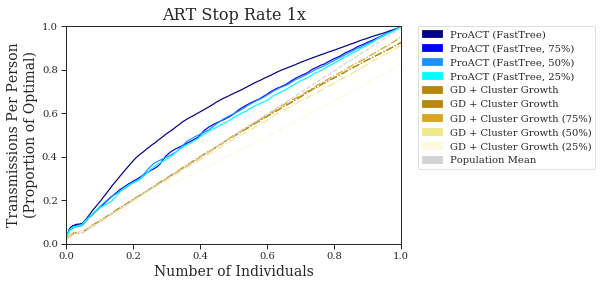

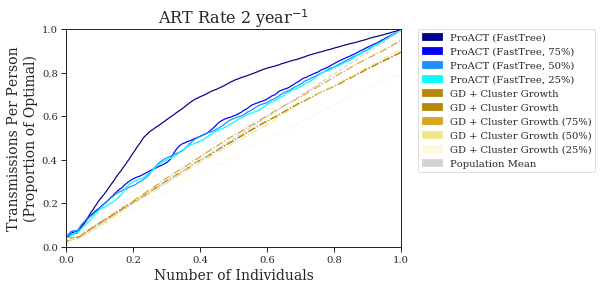

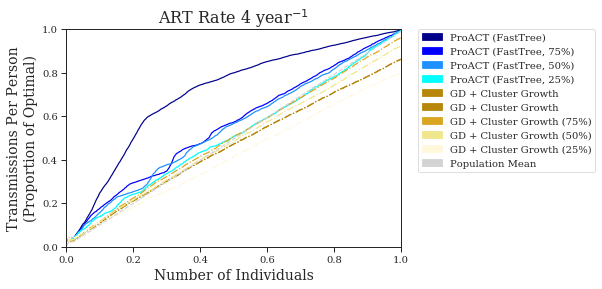

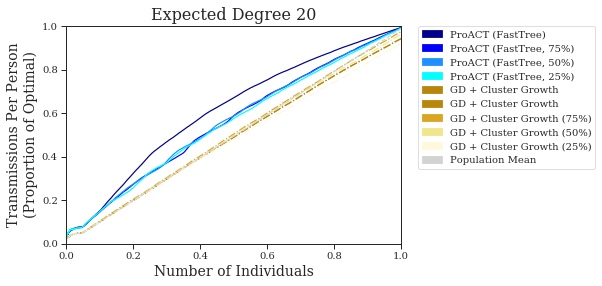

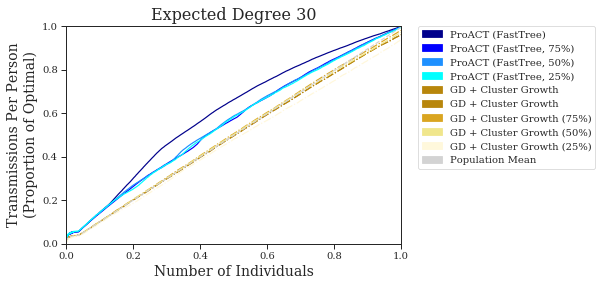

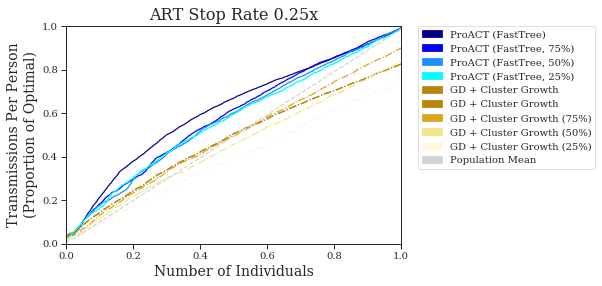

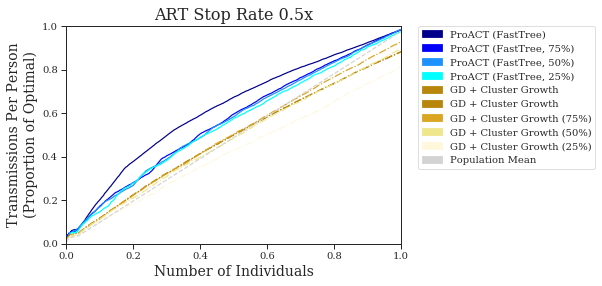

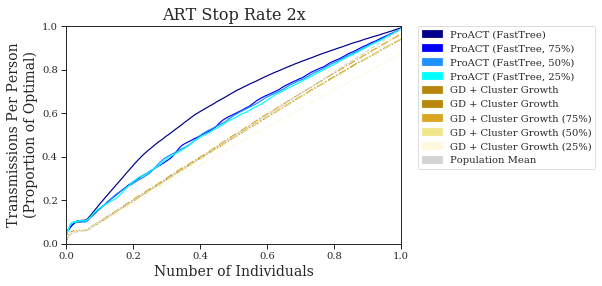

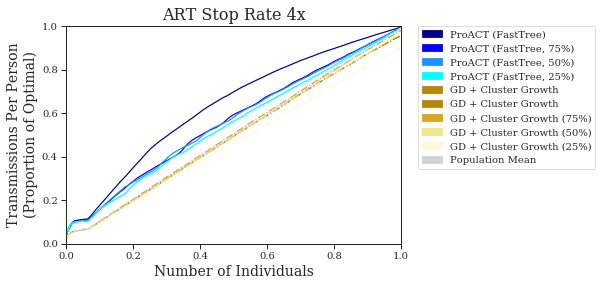

In [12]:
Ms = {
    'main': ['proact.ftmv','proact.ftmv.sub75','proact.ftmv.sub50','proact.ftmv.sub25','hivtrace','hivtrace','hivtrace.sub75','hivtrace.sub50','hivtrace.sub25','expected'],
    'sup': ['proact.true','proact.ftmv'],
}
Ks = ['SAMPLE-FIRSTART_ARTRATE-1','SAMPLE-FIRSTART_ARTRATE-2','SAMPLE-FIRSTART_ARTRATE-4','SAMPLE-FIRSTART_EXPDEGREE-20','SAMPLE-FIRSTART_EXPDEGREE-30','SAMPLE-FIRSTART_STOPRATE-0.25x','SAMPLE-FIRSTART_STOPRATE-0.5x','SAMPLE-FIRSTART_STOPRATE-2x','SAMPLE-FIRSTART_STOPRATE-4x']
ymin = 0
ymax = 1
xmin = 0
xmax = 1
for part,M in Ms.items():
    if part == 'sup':
        suf = '_sup'; continue # skip supplement for now
    else:
        suf = ''
    handles = [Patch(color=metasim['color'][m], label=metasim['label'][m]) for m in M]
    for K in Ks:
        fig = plt.figure()
        for m in M:
            if 'hivtrace' in m or 'proact' in m:
                min_sampled = min([len(l) for l in eff[m][K]])
                cmas_opt = [cma(l[:min_sampled]) for l in eff[m.replace('hivtrace','optimal').replace('proact.ftmv','optimal')][K]]
                cmas_curr = [cma(l[:min_sampled]) for l in eff[m][K]]
                y = [avg([c[i] for c in cmas_curr if i < len(c)])/avg([c[i] for c in cmas_opt if i < len(c)]) for i in range(min_sampled)]
            else:
                min_sampled = min([len(l) for l in eff['optimal'][K]])
                cmas_opt = [cma(l[:min_sampled]) for l in eff['optimal'][K]]
                avg_eff = avg(eff[m][K])
                y = [avg_eff/avg([c[i] for c in cmas_opt if i < len(c)]) for i in range(min_sampled)]
            x = [float(i)/min_sampled for i in range(1,min_sampled+1)]
            plt.plot(x, y, color=metasim['color'][m], linestyle=metasim['linestyle'][m], label=metasim['label'][m])
        #plt.legend(handles=handles, bbox_to_anchor=(0.995, 0.005), loc=4, borderaxespad=0.)
        plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.xlim(xmin=xmin,xmax=xmax)
        plt.ylim(ymin=ymin,ymax=ymax)
        plt.title(metasim['label'][K])
        plt.xlabel("Number of Individuals")
        plt.ylabel("Transmissions Per Person\n(Proportion of Optimal)")
        fig.savefig('figs/results_efficacy_normalized_%s%s.pdf'%(K,suf), format='pdf', bbox_inches='tight')
        if K == 'SAMPLE-FIRSTART_ARTRATE-1':
            for altK in ['SAMPLE-FIRSTART_EXPDEGREE-10','SAMPLE-FIRSTART_STOPRATE-1x']:
                plt.title(metasim['label'][altK])
                fig.savefig('figs/results_efficacy_normalized_%s%s.pdf'%(altK,suf), format='pdf', bbox_inches='tight')

### Comparing Model Conditions

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


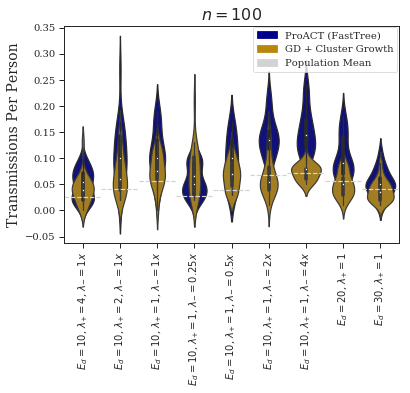

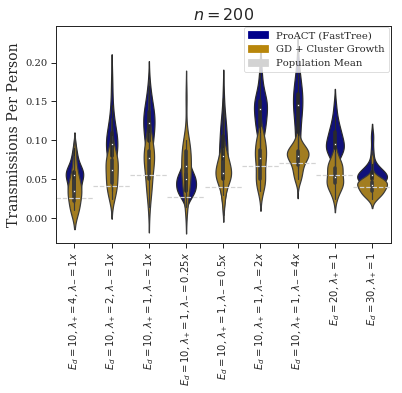

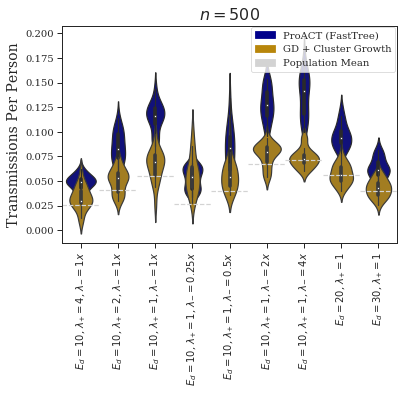

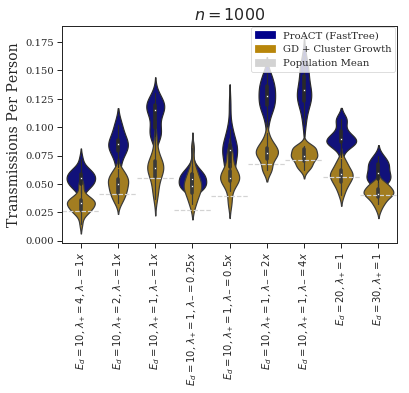

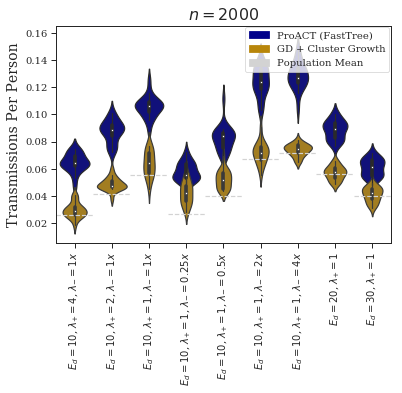

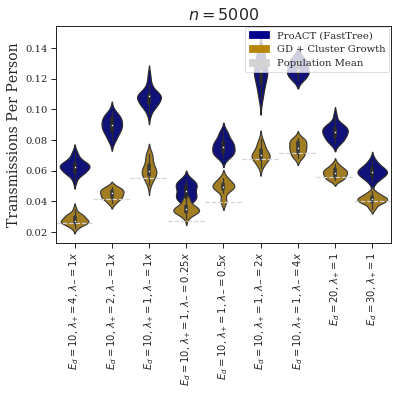

In [13]:
Ks = ['SAMPLE-FIRSTART_ARTRATE-4','SAMPLE-FIRSTART_ARTRATE-2','SAMPLE-FIRSTART_ARTRATE-1','SAMPLE-FIRSTART_STOPRATE-0.25x','SAMPLE-FIRSTART_STOPRATE-0.5x','SAMPLE-FIRSTART_STOPRATE-2x','SAMPLE-FIRSTART_STOPRATE-4x','SAMPLE-FIRSTART_EXPDEGREE-20','SAMPLE-FIRSTART_EXPDEGREE-30']
tr = {
    'SAMPLE-FIRSTART_ARTRATE-1': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=1x$',
    'SAMPLE-FIRSTART_ARTRATE-2': r'$E_{d}=10$, $\lambda_{+}=2$, $\lambda_{-}=1x$',
    'SAMPLE-FIRSTART_ARTRATE-4': r'$E_{d}=10$, $\lambda_{+}=4$, $\lambda_{-}=1x$',
    'SAMPLE-FIRSTART_STOPRATE-0.25x': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=0.25x$',
    'SAMPLE-FIRSTART_STOPRATE-0.5x': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=0.5x$',
    'SAMPLE-FIRSTART_STOPRATE-2x': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=2x$',
    'SAMPLE-FIRSTART_STOPRATE-4x': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=4x$',
    'SAMPLE-FIRSTART_EXPDEGREE-20': r'$E_{d}=20$, $\lambda_{+}=1$',
    'SAMPLE-FIRSTART_EXPDEGREE-30': r'$E_{d}=30$, $\lambda_{+}=1$',
    'SAMPLE-END_ARTRATE-1': r'$E_{d}=10$, $\lambda_{+}=1$, $\lambda_{-}=1x$ (End)',
    'SAMPLE-END_ARTRATE-2': r'$E_{d}=10$, $\lambda_{+}=2$, $\lambda_{-}=1x$ (End)',
    'SAMPLE-END_ARTRATE-4': r'$E_{d}=10$, $\lambda_{+}=4$, $\lambda_{-}=1x$ (End)',
}
Ms = ['proact.ftmv','hivtrace']
Ns = [100,200,500,1000,2000,5000]
handles = [Patch(color=metasim['color'][m], label=metasim['label'][m]) for m in Ms+['expected']]
ymin = None #-0.05
ymax = None #0.8
for n in Ns:
    fig = plt.figure()
    for m in Ms:
        x = list(); y = list()
        for K in Ks:
            y += [avg(l[:n]) for l in eff[m][K]]; x += [tr[K]]*len(eff[m][K])
        violinplot(x=x, y=y, color=metasim['color'][m], labels=metasim['label'][m])
    xlim = plt.xlim()
    for m in ['expected']:#,'optimal']: # plot expected and optimal lines
        for i,K in enumerate(Ks):
            if m == 'expected':
                x = [i-0.5,i+0.5]; y = [avg(eff[m][K])]*2
            else:
                pass
            plt.plot(x, y, linestyle=metasim['linestyle'][m], color=metasim['color'][m])
    plt.legend(handles=handles, bbox_to_anchor=(0.995, 0.995), loc=1, borderaxespad=0.)
    plt.xlim(xlim)
    plt.ylim(ymin=ymin,ymax=ymax)
    plt.title(r"$n=%d$" % n)
    plt.ylabel("Transmissions Per Person")
    plt.xticks(rotation=90)
    fig.savefig('figs/results_efficacy_n%d.pdf'%n, format='pdf', bbox_inches='tight')